In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [337]:
class Model(torch.nn.Module):
    def __init__(self, syllable_count, syllable_features, fully_connected):
        super(Model, self).__init__()
        '''
        Purpose:
            - Initializes the song bird circuit 
            
        Args:
            - 
        
        Returns:
            - 
        '''

        self.HVC_size = syllable_count
        
        self.HVC = nn.Linear(syllable_count, self.HVC_size, bias=False)

        self.RA = nn.Linear(self.HVC_size, syllable_features, bias=False)

        self.LMAN_Size = syllable_features * 2
        self.Area_X_size = self.HVC_size * self.LMAN_Size

        # Technically, Area_X has RA * HVC amount of neurons, but for simplicity, we will assume that it is just RA * 1
        self.Area_X =  nn.Linear(self.HVC_size, self.Area_X_size, bias=False)
        self.LMAN =  nn.Linear(self.Area_X_size, self.LMAN_Size, bias=False)

        if fully_connected == True:
            self.init_fully_connected_weights()
        else:
            self.init_weights()


    def forward_HVC(self, syllable):
        x = self.HVC(syllable)
        return F.relu(x)
    
    def forward_RA(self, hvc_neurons):
        x = self.RA(hvc_neurons)
        return F.relu(x)
    
    def forward_Area_X(self, hvc_neurons):
        x = self.Area_X(hvc_neurons)
        return F.relu(x)
    
    def forward_LMAN(self, hvc_neurons):
        x = self.LMAN(hvc_neurons)
        return F.relu(x)
    
    def set_weights(self, layer, weight_matrix):
        """
        Purpose:
            - Sets the weights of the layer
        
        Args:
            - layer: the layer to set the weights of
            - weight_matrix: the weight matrix to set the weights to

        Returns:
            None
        """

        weight_matrix = nn.Parameter(weight_matrix)

        if layer == "HVC":
            self.HVC.weight = weight_matrix
        if layer == "RA":
            self.RA.weight = weight_matrix
        if layer == "Area_X":
            self.Area_X.weight = weight_matrix
        if layer == "LMAN":
            self.LMAN.weight = weight_matrix
        
    def init_fully_connected_weights(self):
         # set all weights between syllable and HVC to 0
        self.set_weights("HVC", torch.zeros(self.HVC_size, self.HVC_size))

        for i in range(self.HVC_size):
            for j in range(self.HVC_size):
                if i == j:
                    # get weight matrix of HVC
                    weight_matrix = self.HVC.weight
                    weight_matrix = torch.tensor(weight_matrix)
                    weight_matrix[i][j] = torch.tensor([1.0])
                    self.set_weights("HVC", weight_matrix)

        # set all weights between AreaX and LMAN to 0
        self.set_weights("LMAN", torch.zeros(self.LMAN_Size, self.Area_X_size))

        for i in range(self.LMAN_Size):
            start = i * self.HVC_size
            stop = start + self.HVC_size
            for j in range(start, stop):
                weight_matrix = self.LMAN.weight
                weight_matrix = torch.tensor(weight_matrix)
                weight_matrix[i][j] = torch.tensor([1.0])
                self.set_weights("LMAN", weight_matrix)


    def init_weights(self):
        """
        Purpose:
            - removes some weights between HVC_AreaX 
                - in areaX there are LMAN * HVC number of neurons
                - each areaX neuron is connected to a unique combination of LMAN and HVC neurons
            - removes weights between AreaX and LMAN
                - many areaX neurons converge on a single LMAN neuron 
            - sets syllable to HVC weights to one (also one to one mapping)

        Args:
            None

        Returns:
            None
        """

        # set all weights between syllable and HVC to 0
        self.set_weights("HVC", torch.zeros(self.HVC_size, self.HVC_size))

        for i in range(self.HVC_size):
            for j in range(self.HVC_size):
                if i == j:
                    # get weight matrix of HVC
                    weight_matrix = self.HVC.weight
                    weight_matrix = torch.tensor(weight_matrix)
                    weight_matrix[i][j] = torch.tensor([1.0])
                    self.set_weights("HVC", weight_matrix)


        # set all weights between HVC and AreaX to 0
        self.set_weights("Area_X", torch.zeros(self.Area_X_size, self.HVC_size))

        for i in range(self.Area_X_size):
            for j in range(self.HVC_size):
                # hard to explain see picture on my phone from apr 30 2023
                if j == (i % self.HVC_size): 
                    # get weight matrix of AreaX
                    weight_matrix = self.Area_X.weight
                    weight_matrix = torch.tensor(weight_matrix)
                    weight_matrix[i][j] = torch.rand(1)
                    self.set_weights("Area_X", weight_matrix)

        # set all weights between AreaX and LMAN to 0
        self.set_weights("LMAN", torch.zeros(self.LMAN_Size, self.Area_X_size))

        for i in range(self.LMAN_Size):
            start = i * self.HVC_size
            stop = start + self.HVC_size
            for j in range(start, stop):
                weight_matrix = self.LMAN.weight
                weight_matrix = torch.tensor(weight_matrix)
                weight_matrix[i][j] = torch.tensor([1.0])
                self.set_weights("LMAN", weight_matrix)
              

    def hebbian_update(self, pre_layer_activations, post_layer_activations, post_layer_weights, learning_rate):
        """
        Purpose:
            - if the pre_layer and post_layer fire in the same cycle, then the weights between them are updated by the learning rate in positive direction
            - if not, then the weights are updated in negative direction by the learning rate

        Args:
            - pre_layer_activations: the activations of the pre layer
            - post_layer_activations: the activations of the post layer

        Returns:
            - post_weights: the updated weights between the pre and post layer (belongs to the post layer)
        """

        post_weights = post_layer_weights

        for i in range(len(post_layer_activations)):
            for j in range(len(pre_layer_activations)):
                if pre_layer_activations[j] != 0 and post_layer_activations[i] != 0:
                    post_weights[i][j] += learning_rate
                else:
                    post_weights[i][j] -= learning_rate

        return post_weights 

    def HVC_X_update_rule(self, area_x_weights, reward, learning_rate, LMAN_activation, hvc_activation, noise, fully_connected):
    
        if fully_connected == False:
            for i in range(self.Area_X_size):
                for j in range(self.HVC_size):
                    if j == (i % self.HVC_size):
                        LMAN_index = i // self.HVC_size
                        LMAN_index += 1 

                        if hvc_activation[j] != 0:
                            weight_update = learning_rate * noise[LMAN_index-1]   
                            area_x_weights[i][j] += torch.tensor(weight_update)        
                       
        if fully_connected == True:
            for i in range(self.Area_X_size):
                for j in range(self.HVC_size):
                    LMAN_index = i // self.HVC_size
                    LMAN_index += 1 

                    if hvc_activation[j] != 0:
                        weight_update = learning_rate * noise[LMAN_index-1]   
                        area_x_weights[i][j] += torch.tensor(weight_update)        

        return area_x_weights



    def visualize_layer_weights(self, layer):
        """
        Purpose:
            - Visualizes the weights of the layer

        Args:
            - layer: the layer to visualize

        Returns:
            None
        """

        if layer == "HVC":
            weights = self.HVC.weight
        elif layer == "RA":
            weights = self.RA.weight
        elif layer == "Area_X":
            weights = self.Area_X.weight
        elif layer == "LMAN":
            weights = self.LMAN.weight
        
        weights = weights.detach().numpy()
        fig, ax = plt.subplots()
        im = ax.imshow(weights, cmap='coolwarm')

        # Add a colorbar to the heatmap
        cbar = ax.figure.colorbar(im, ax=ax)

        # Add value labels to the heatmap
        for i in range(weights.shape[0]):
            for j in range(weights.shape[1]):
                ax.text(j, i, '{:.2f}'.format(weights[i, j]), ha='center', va='center', color='w')

        # Add a title and axis labels to the heatmap
        ax.set_title('Weight Matrix Heatmap')
        ax.set_xlabel('Input Features')
        ax.set_ylabel('Output Features')

        # Show the heatmap
        plt.show()


    def print_layer_weights(self, layer):
        """
        Purpose:
            - Prints the weights of the layer in a heatmap format

        Args:
            - layer: the layer to print

        Returns:
            None
        """

        if layer == "HVC":
            weights = self.HVC.weight
        if layer == "RA":
            weights = self.RA.weight
        if layer == "Area_X":
            weights = self.Area_X.weight
        if layer == "LMAN":
            weights = self.LMAN.weight
        
        print(weights)

    def negative_MSE_reward(self, network_output, target, scaling_factor):
        """
        Purpose:
            - Calculates the negative MSE reward for the network

        Args:
            - Network output
            - Target

        Returns:   
            - reward: the negative MSE reward
        """

        reward = -scaling_factor * F.mse_loss(network_output, target)
        return reward
    
    def MSE(self, output, target):
        """
        Purpose:
            - Calculates the MSE between the output and target

        Args:
            - output
            - target

        Returns:
            - MSE
        """

        return F.mse_loss(output, target)
    
    def LMAN_activation_to_noise(self, LMAN_output):
        """
        Purpose:
            - Adds noise to the LMAN activations (rn just a normal distribution)

        Args:
            None

        Returns:
            - Noise vector 
        """

        # normal distribution with mean 0 and std .01
        noise = torch.normal(0, .001, size=(len(LMAN_output),))

        LMAN_noise = LMAN_output + noise

        return LMAN_noise, noise
    
    def LMAN_RA_bias(self, RA, LMAN_bias):
        new_RA = torch.zeros(len(RA))
        
        for i in range(len(RA)):
            bias_total = 0
            for j in range(i*2, (i*2)+2):
                bias_total += LMAN_bias[j]

            new_RA[i] = RA[i] + bias_total
        
        # print(f"RA inside LMAN_RA_bias: {new_RA}")
        return new_RA
    
    def get_weights(self, layer):
        if layer == "HVC":
            weights = self.HVC.weight
        elif layer == "RA":
            weights = self.RA.weight
        elif layer == "Area_X":
            weights = self.Area_X.weight
        elif layer == "LMAN":
            weights = self.LMAN.weight

        return torch.tensor(weights)
    
    def reward_prediction_error(self, without_LMAN, with_LMAN, target):
        without_LMAN_error = self.MSE(without_LMAN, target)
        with_LMAN_error = self.MSE(with_LMAN, target)

        reward_prediction_error =  without_LMAN_error - with_LMAN_error

        return reward_prediction_error
    
    def LMAN_output_sign_flip(self, LMAN_output):
        """
        Purpose:
            - flips the sign of the LMAN output of every other LMAN neuron

        Args:
            - LMAN_output

        Returns:
            - LMAN_output with flipped sign
        """

        for i in range(len(LMAN_output)):
            if i % 2 == 0:
                LMAN_output[i] = -LMAN_output[i]

        return LMAN_output
    
    def cosine_similarity(self, target, actual):
        # cosine similarity
        cosine_similarity = F.cosine_similarity(target, actual, dim=0)
        return cosine_similarity


    def euclidean_distance(self, target, actual):
        eucledian_distance = F.pairwise_distance(target, actual, p=2)
        return eucledian_distance

### Testing Grounds

In [348]:
# ignore for now
hvc_neurons = 2
syllable_count = hvc_neurons

reward_history = []
RA_output_history = []

syllable_features = 1
fully_connected = False

epochs = 10000

model = Model(syllable_count, syllable_features, fully_connected=fully_connected)

# initial hidden state
hidden_state = torch.zeros(hvc_neurons)

dummy_HVC_input_1 = torch.tensor([1.0, 0.0])
dummy_HVC_input_2 = torch.tensor([0.0, 1.0])

dummy_target_1 = torch.tensor([1.0])
dummy_target_2 = torch.tensor([-1.0])

# # set weights to zeros 
model.set_weights("Area_X", torch.zeros((model.Area_X_size, model.HVC_size)))


prev_reward = -1e8

for epoch in range(epochs):
    # HVC -> RA -> RA_output
    
    if epoch < epochs/2:
        hvc_state = model.forward_HVC(dummy_HVC_input_1)
        dummy_target = dummy_target_1
    else:   
        hvc_state = model.forward_HVC(dummy_HVC_input_2)
        dummy_target = dummy_target_2
    
    print(f"dummt target: {dummy_target}")
    print(f"hvc_state: {hvc_state}")

    ra_output = model.forward_RA(hvc_state)

    ra_output_without_LMAN = ra_output

    # HVC -> Area_X -> LMAN (random normal for now)
    Area_X_output = model.forward_Area_X(hvc_state)
    print(f"Area_X_output: {Area_X_output}")
    LMAN_output = model.forward_LMAN(Area_X_output)
    
    LMAN_output, noise = model.LMAN_activation_to_noise(LMAN_output)
    print(f"LMAN_output: {LMAN_output}")
    RA_output_with_LMAN = model.LMAN_RA_bias(ra_output, LMAN_output)
    RA_output_history.append(RA_output_with_LMAN)

    # print(f"ra_output without LMAN: {ra_output_without_LMAN}")
    print(f"RA_output with LMAN: {RA_output_with_LMAN}")

    cosine_distance = model.cosine_similarity(RA_output_with_LMAN, dummy_target)
    eucledian_distance = model.euclidean_distance(RA_output_with_LMAN, dummy_target)

    reward = cosine_distance - eucledian_distance

    reward_history.append(reward.detach().numpy())
    RA_output_history.append(RA_output_with_LMAN.detach().numpy())
    
    # print(f"reward: {reward}")

    # areaX update
    if reward > prev_reward:
        weight_matrix = model.HVC_X_update_rule(area_x_weights=model.get_weights("Area_X"), LMAN_activation=LMAN_output, hvc_activation=hvc_state, reward=reward, learning_rate=1, noise=noise, fully_connected=fully_connected)
        model.set_weights("Area_X", weight_matrix)

    prev_reward = reward 
    print(f"_________________________________________________________")



/var/folders/s5/0yhgng1n5k12_prdv1mgd4hw0000gn/T/ipykernel_49884/2602978439.py:125: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight_matrix = torch.tensor(weight_matrix)
/var/folders/s5/0yhgng1n5k12_prdv1mgd4hw0000gn/T/ipykernel_49884/2602978439.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight_matrix = torch.tensor(weight_matrix)
/var/folders/s5/0yhgng1n5k12_prdv1mgd4hw0000gn/T/ipykernel_49884/2602978439.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight_matrix = torch.tensor(weight_matrix)
/var/folders/s5/0yhgng

dummt target: tensor([1.])
hvc_state: tensor([1., 0.], grad_fn=<ReluBackward0>)
Area_X_output: tensor([0., 0., 0., 0.], grad_fn=<ReluBackward0>)
LMAN_output: tensor([-0.0020,  0.0013], grad_fn=<AddBackward0>)
RA_output with LMAN: tensor([0.6986], grad_fn=<CopySlices>)
_________________________________________________________
dummt target: tensor([1.])
hvc_state: tensor([1., 0.], grad_fn=<ReluBackward0>)
Area_X_output: tensor([0.0000, 0.0000, 0.0013, 0.0000], grad_fn=<ReluBackward0>)
LMAN_output: tensor([-0.0003,  0.0014], grad_fn=<AddBackward0>)
RA_output with LMAN: tensor([0.7005], grad_fn=<CopySlices>)
_________________________________________________________
dummt target: tensor([1.])
hvc_state: tensor([1., 0.], grad_fn=<ReluBackward0>)
Area_X_output: tensor([0.0000, 0.0000, 0.0014, 0.0000], grad_fn=<ReluBackward0>)
LMAN_output: tensor([0.0018, 0.0011], grad_fn=<AddBackward0>)
RA_output with LMAN: tensor([0.7022], grad_fn=<CopySlices>)
_______________________________________________

Text(0, 0.5, 'Reward')

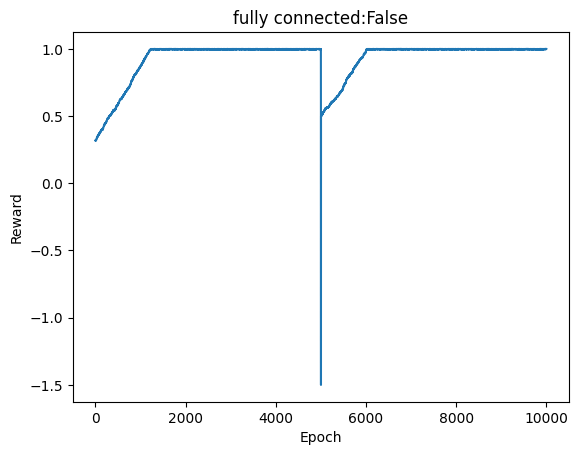

In [347]:
# plot reward history
plt.plot(reward_history)
# add title wheter fully connected or not
plt.title("fully connected:" + str(fully_connected))
plt.xlabel("Epoch")
plt.ylabel("Reward")

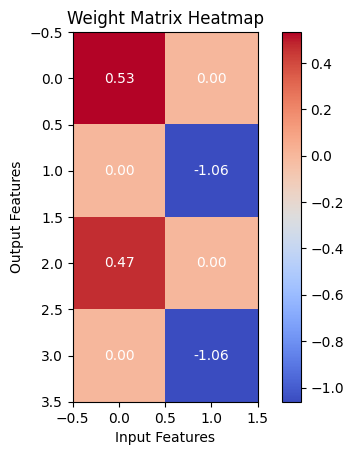

In [343]:
model.visualize_layer_weights("Area_X")